# LIBRARIES



In [1]:
#run only once, 
!pip install ghhops-server flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 12.3 MB/s 
  Created wheel for rhino3dm: filename=rhino3dm-7.14.2-cp37-cp37m-linux_x86_64.whl size=4995195 sha256=777e53363733ad82a96173b7c74e979f5e429934314a70a7505619a9037a543e
  Stored in directory: /root/.cache/pip/wheels/54/fd/27/c1c91b5631a9dcb2291a8541117b0040fe461756f9c77430fc
Successfully built rhino3dm


In [2]:
# Import standard Libraries
import pandas as pd
import seaborn as sns
import altair as alt
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
from flask import Flask
from flask_ngrok import run_with_ngrok
import ghhops_server as hs
import numpy
import rhino3dm


sns.set(rc={'figure.figsize':(10,10)})
print("imports ok")

imports ok


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# LOAD/SCALING

In [4]:
# Load data file
data = pd.read_csv('/content/gdrive/MyDrive/AIA Studio/6/Vienna_6_radiation', delimiter= " ")
data

OSM_id  Building_Height  Building_Volume    Roof_Area      Radiation
0      12582763              6.0      3342.458194   255.708130  177700.563050
1      11890773              6.0     27029.167219  2231.509699  956739.831463
2      11890772              6.0     10215.515500   793.511448  412265.306277
3      11890771              6.0      3322.850269   228.418691  164588.354205
4       9351278             30.0    207514.602615  1554.606785  929729.345880
...         ...              ...              ...          ...            ...
3996  666513141              6.0       357.034208    33.168000   11372.836035
3997  666513140              6.0       363.145890    34.949566   11372.836035
3998  666513139              6.0       385.882949    48.474146   24167.276575
3999  666513138              6.0       267.506422    35.746492   11372.836035
4000  666513138              6.0       267.506422    35.746492    8936.186069

[4001 rows x 5 columns]

In [5]:
#declare features
X = data[['Building_Height', 'Building_Volume', 'Roof_Area'  ]]   

# Load and instantiate a StandardSclaer 
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()

# Apply the scaler to our X-features
X_scaled = scalerX.fit_transform(X)

print(X_scaled)

[[-0.08050734  0.03416092  0.52347704]
 [-0.08050734  0.74942057  7.33684023]
 [-0.08050734  0.24170434  2.37804047]
 ...
 [-0.08050734 -0.0551178  -0.19114958]
 [-0.08050734 -0.05869237 -0.23503968]
 [-0.08050734 -0.05869237 -0.23503968]]


In [6]:
#declare regression target
y = data.loc[:, ['Radiation']].to_numpy()

#y = y.reshape(-1, 1)
from sklearn.preprocessing import MinMaxScaler
scalerY = MinMaxScaler()

#In this case it makes sense to use MinMax scaling because the wage seems like a relative range
# Apply the scaler to our Y-features
y_scaled = scalerY.fit_transform(y)

print(y_scaled.shape)
print(y_scaled)

(4001, 1)
[[0.03822577]
 [0.20715303]
 [0.0890889 ]
 ...
 [0.00493353]
 [0.00215918]
 [0.00163081]]


# TRAINING


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.2, random_state = 20)

In [9]:
import tensorflow as tf

# Instantiate a sequential model
model = tf.keras.models.Sequential()
n_cols = X_scaled.shape[1]  

# Add 2 dense layers of 18 and 12 neurons each
model.add(tf.keras.layers.Dense(3, input_shape=(n_cols,), activation='relu'))
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='relu'))
  
# Add a dense layer with 1 value output
# model.add(tf.keras.layers.Dense(9, activation= "sigmoid")) # OUTPUT LAYER
  
# Compile the model model 
model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["accuracy"])
# model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3)                 12        
                                                                 
 dense_4 (Dense)             (None, 15)                60        
                                                                 
 dense_5 (Dense)             (None, 8)                 128       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


In [12]:
# history = model.fit(X_train, y_train, epochs=400, batch_size=200, validation_split=0.2)
history = model.fit(X_train, y_train, epochs=800, validation_split=0.2)

Epoch 1/800
80/80 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 3.9063e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 2/800
80/80 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 3.9063e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 3/800
80/80 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 3.9063e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 4/800
80/80 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 3.9063e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 5/800
80/80 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 3.9063e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 6/800
80/80 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 3.9063e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 7/800
80/80 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 3.9063e-04 - v

[DEBUG] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
[DEBUG] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[DEBUG] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
[DEBUG] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
[DEBUG] findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
[DEBUG] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[DEBUG] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
[DEBUG] findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
[DEBUG] findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
[DEBUG] findfont: score(<Font 'cmtt10' (cmtt10.ttf

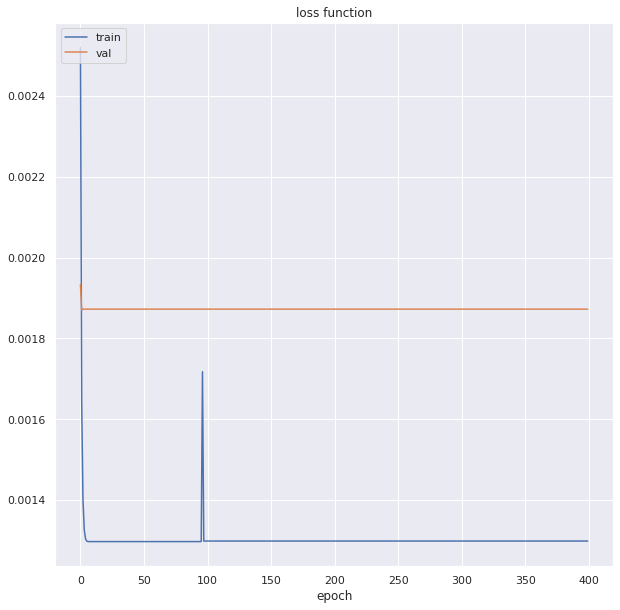

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss function')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# MODEL SAVING

In [ ]:
#https://www.tensorflow.org/guide/keras/save_and_serialize
model.save("/content/gdrive/MyDrive/AIA Studio/6/radiation-itr-3.h5")

scalerX_filename = "/content/gdrive/MyDrive/AIA Studio/6/scalerXAtoB.save"
joblib.dump(scalerX, scalerX_filename)

scalerY_filename = "/content/gdrive/MyDrive/AIA Studio/6/scalerYAtoB.save"
joblib.dump(scalerY, scalerY_filename)

# HOPS

In [ ]:
# 1 --- import model

path = "/content/gdrive/MyDrive/AIA Studio/5/Copy of solar_it2.h5"
model = tf.keras.models.load_model(path)

[DEBUG] Creating converter from 3 to 5


In [ ]:
# from sklearn.externals import joblib
# 2 --- set up scaler variables
# path1 = "/content/gdrive/MyDrive/AIA Studio/5/Copy of scalerXAtoB.save"
scalerX = joblib.load("/content/gdrive/MyDrive/AIA Studio/5/Copy of scalerXAtoB.save")
scalerY = joblib.load("/content/gdrive/MyDrive/AIA Studio/5/Copy of scalerYAtoB.save")
# scalerY = joblib.load("scalerYAtoB.save")

In [ ]:
def myMLPredictions(Building_Height, Building_Volume, Roof_Area):

    # Create Input Array
    new_data = pd.DataFrame([[Building_Height, Building_Volume, Roof_Area]])

    # Scale Input to match the same format from the trained model
    scaled_input = scalerX.transform(new_data)

    # Generate Predictions from Scaled Input using model.predict
    #https://www.tensorflow.org/api_docs/python/tf/keras/Model

    # 01// predict
    out = model.predict(scaled_input)
    #02 // inverse scaling
    # predictions = scalerY.inverse_transform(out)
    predictions = scalerY.inverse_transform(out)

    
    #Flatten predictions list to be readable for hops
    pred_list = predictions.tolist()
    flat_list = []

    for i in pred_list:
        flat_list += i

    # Set each prediction value to a variable
    Radiation = flat_list[0]

   
    return Radiation

In [ ]:
app = Flask(__name__)
#using ngrok library to stream data
run_with_ngrok(app) 
hops = hs.Hops(app)

# -- ATOB MODEL

@hops.component(
    "/Roof-radiation-prediction",
    name="Roof radiation prediction",
    description="Machine Learning Roof Radiation Predicion for Vienna",
    inputs=[
        hs.HopsNumber("Building_Height", "Building_Height", "Building_Height"),
        hs.HopsNumber("Building_Volume", "Building_Volume", "Building_Volume"),
        hs.HopsInteger("Roof_Area", "Roof_Area", "Roof_Area"),
    ],
    outputs=[
        hs.HopsNumber("Radiation", "Radiation", "Radiation")
    ]
)

def myMLFunctionAtoB(Building_Height, Building_Volume, Roof_Area):
    return myMLPredictions(Building_Height, Building_Volume, Roof_Area)

In [ ]:
#run the app
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


[INFO]  * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
[DEBUG] Starting new HTTPS connection (1): bin.equinox.io:443
[DEBUG] https://bin.equinox.io:443 "GET /c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip HTTP/1.1" 200 13832437
[DEBUG] Starting new HTTP connection (1): localhost:4040
[DEBUG] http://localhost:4040 "GET /api/tunnels HTTP/1.1" 200 787


 * Running on http://19f2-34-90-2-137.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


[INFO] 127.0.0.1 - - [20/Jun/2022 06:48:23] "GET / HTTP/1.1" 200 -
[INFO] 127.0.0.1 - - [20/Jun/2022 06:48:52] "GET /Roof-radiation-prediction HTTP/1.1" 200 -
[INFO] Solving using legacy API: <HopsComponent /Roof-radiation-prediction [Building_Height,Building_Volume,Roof_Area -> Roof radiation prediction -> Radiation] >
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
[INFO] 127.0.0.1 - - [20/Jun/2022 06:49:40] "POST /solve HTTP/1.1" 200 -
[INFO] Solving using legacy API: <HopsComponent /Roof-radiation-prediction [Building_Height,Building_Volume,Roof_Area -> Roof radiation prediction -> Radiation] >
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
[INFO] 127.0.0.1 - - [20/Jun/2022 